# MLP (Multilayer Perceptron) - Backpropagation

In [41]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
from random import seed
from random import randrange
from random import random
import matplotlib.pyplot as plt 
%matplotlib inline

class RNA:

    
    def __init__(self, rate=0.5, epoch=100, error_rate=0.5, output_mode='Logistics'):
        seed(1)
        self.rate = rate
        self.epoch = epoch
        self.inputs = 0
        self.outputs = 0
        self.hiddens = 0
        self.errors = list()
        self.score = 0
        self.network = list()
        self.data = list()
        self.filter = dict()
        self.error_rate = error_rate
        self.mode = output_mode
    

    def show(self):
        out = {
            'rate': self.rate,
            'epoch': self.epoch,
            'inputs': self.inputs,
            'outputs': self.outputs,
            'hiddens': self.hiddens,
            'errors': self.errors,
            'score': self.score,
            'filter': self.filter
        }
        print(out)
    

    def geo_mean(self, inputs, outputs):
        return math.floor(math.sqrt((float(inputs * outputs))))
    
    
    def load_data(self, path=''):
        if path != '':
            df = pd.read_csv(path)
            for col in df.drop(columns="classe", axis=1):
                df[str(col)] = df[str(col)].astype(float)
            self.data = df.values.tolist()
            
        self.inputs = len(self.data[0]) - 1
        
        last = len(self.data[0]) - 1
        
        col_class = [row[last] for row in self.data]
        self.outputs = len(set(col_class))
        self.filter = dict()
        for i, value in enumerate(set(col_class)):
            self.filter[value] = i
            
        for row in self.data:
            row[last] = self.filter[row[last]]
        self.hiddens = self.geo_mean(self.inputs, self.outputs)
        self.shuffle()
        self.normalize()
    
    def shuffle(self):
        temp = list(self.data)
        self.data = list()
        while len(temp) > 0:
            index = randrange(len(temp))
            self.data.append(temp.pop(index))
    
    
    def normalize(self):
        norm = list()
        state = [[min(col), max(col)] for col in zip(*self.data)]
        for row in self.data:
            for i in range(len(row) - 1):
                row[i] = (row[i] - state[i][0]) / (state[i][1] - state[i][0])
    

    def init_network(self):
        self.network = list()
        # hidden = [{'W': np.random.rand(self.inputs + 1)} for _ in range(self.hiddens)]
        hidden = [{'W':[random() for _ in range(self.inputs + 1)]} for _ in range(self.hiddens)]
        self.network.append(hidden)
        # criação dos neurônios de saída
        #output = [{'W':np.random.rand(self.hiddens + 1)} for _ in range (self.outputs)]
        output = [{'W':[random() for _ in range(self.hiddens + 1)]} for _ in range(self.outputs)]
        self.network.append(output)
    

    def activate(self, weight, inputs):
        act = weight[-1]
        for i in range(len(weight) - 1):
            act += weight[i] * inputs[i]
        return act
     

    def output_function(self, value):
        if self.mode == 'Linear':
            return value / 10.0
        elif self.mode == 'Logistics':
            return 1.0 / (1.0 + math.exp(-value))
        else:
            return math.tanh(value)
    
    def gradient(self, value):
        if self.mode == 'Linear':
            return 1.0 / 10.0
        elif self.mode == 'Logistics':
            x = self.output_function(value)
            return x * (1.0 - x)
        else:
            return 1.0 - (self.output_function(value) ** 2)
    
    def forward_propagate(self, row):
        temp_inputs = row
        for layer in self.network:
            news = list()
            for neuron in layer:
                act = self.activate(neuron['W'], temp_inputs)
                neuron['OUTPUT'] = self.output_function(act)
                news.append(neuron['OUTPUT'])
            temp_inputs = news
        return temp_inputs
    
    def backward_propagate_error(self, rec):
        for i in reversed(range(len(self.network))):
            layer = self.network[i]
            errors = list()
            if i != len(self.network)-1:
                for j in range(len(layer)):
                    error = 0.0
                    for neuron in self.network[i + 1]:
                        error += (neuron['W'][j] * neuron['DELTA'])
                    errors.append(error)
            else:
                for j in range(len(layer)):
                    neuron = layer[j]
                    errors.append(rec[j] - neuron['OUTPUT'])
            for j in range(len(layer)):
                neuron = layer[j]
                neuron['DELTA'] = errors[j] * self.gradient(neuron['OUTPUT'])
    
    def update_weights(self, row):
        for i in range(len(self.network)):
            inputs = row[:-1]
            if i != 0:
                inputs = [neuron['OUTPUT'] for neuron in self.network[i - 1]]
            for neuron in self.network[i]:
                for j in range(len(inputs)):
                    neuron['W'][j] += self.rate * neuron['DELTA'] * inputs[j]
                neuron['W'][-1] += self.rate * neuron['DELTA']
    
    def train(self, path='', data=[]):
        if len(data) == 0:
            self.data = data
        self.load_data(path)
        self.init_network()
        error = 100
        epochs = 0
        while (self.error_rate < error) & (self.epoch > epochs):
            for row in self.data:
                outs = self.forward_propagate(row)
                rec = np.zeros(self.outputs)
                rec[row[-1]] = 1
                error += sum([(rec[i] - outs[i]) * self.gradient(outs[i]) for i in range(len(rec))])
                self.backward_propagate_error(rec)
                self.update_weights(row)
            self.errors.append(error)
            epochs += 1
    
    def predict(self, row):
        outputs = self.forward_propagate(row)
        return outputs.index(max(outputs))
    
    def accuracy(self, facts, predicteds, dist):
        res = 0
        for i in range(len(facts)):
            if facts[i] == predicteds[i]:
                res += 1
        acc = res / float(len(facts)) * 100.0        
        
        matrix = [[0 for _ in range(len(dist))] for _ in range(len(dist))]        
        for i in range(len(facts)):
            matrix[int(facts[i])][int(predicteds[i])] += 1
        df = pd.DataFrame(data=matrix, columns=list(self.filter), index=list(self.filter))
        return (acc, df)
    
    def test(self, path='', data=''):
        dist = list(self.filter)
        if len(data) == 0:
            self.data = data
        self.load_data(path)
        pred = list()
        for row in self.data:
            pred.append(self.predict(row))
        fact = [row[-1] for row in self.data]
        return self.accuracy(fact, pred, dist)

# Parameters
*The parameters that must be passed for the use of the neural network*

`learning_rate` is the rate of learning of the Neural Network

**VALUES**
- *0 ... 1*


In [42]:
learning_rate = 0.6

`epochs` is the number of times that the learning process is runned

**VALUES**
- *1...INF*

In [43]:
epochs = 50

`error_rate` is the error rate that learning should reach

**VALUES**
- *0...INF*

In [44]:
error_rate = 1

`output_mode` is the output function of each neuron in the Neural Network

**VALUES**
- *Linear* 
    * `f(net) = net / 10.0`
    * `f(net)' = 1.0 / 10.0`
- *Logistics* 
    * `f(net) = 1.0 / (1.0 + exp(-net))`
    * `f(net)' = exp(-net) * (1.0 - exp(-net))`
- *Hiperbolic Tangent*
    * `f(net) = tanh(net)`
    * `f(net)' = 1.0 - tanh(net) ** 2`

In [45]:
output_mode = 'Logistics'

# Train
*The trainning process of ANN*

- Receive only a string that represents the ``path`` of csv file train 

In [46]:
rna = RNA(rate=learning_rate, epoch=epochs, error_rate=error_rate, output_mode=output_mode)
rna.train(path='train.csv')

## Error rate index
*The error rate, from the beginning to the end of the training based on the number of epochs runned*

<AxesSubplot:>

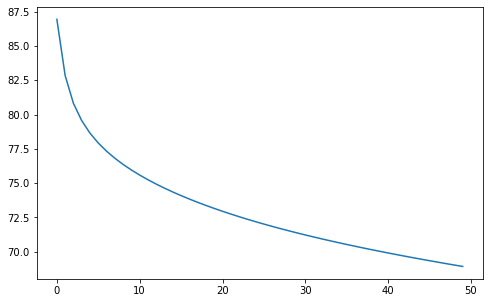

In [47]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=rna.errors)

# Test
*Run a test based on training, but with different values, to knows how accurate is the neural network*
- Receive the ``path`` of csv file test, and return the ``score`` and confusion ``matrix`` of the test

In [38]:
score, matrix = rna.test(path='test.csv')

Carregado
Bagunçado
Normalizado


## Confusion Matrix
*The confusion matrix quantifies how many examples from the test database are correctly classified by the model built*


In [39]:
matrix

,CD,CE,CC,CA,CB
CD,75,0,0,0,0
CE,0,66,0,0,0
CC,0,0,102,0,0
CA,0,0,0,56,0
CB,0,0,0,0,53


## Score (Accuracy)
*Shows the percentage of correctness of the test performed with the neural network training*

In [40]:
score

100.0